In [1]:
import spacy 
import re 
import pandas as pd
from spacy.lang.en import English
from collections import Counter
from itertools import chain
import ahocorasick
import ast
from analyze_m_data import get_occupations_list_en, get_occupations_list
from spacy.lang.de import German
from spacy.lang.it import Italian
from spacy.lang.es import Spanish 
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from operator import itemgetter

In [51]:
def remove_html_en(filename):
    # remove html, clean and lowercase intro texts
    new_df = pd.read_csv(filename, names= ['wikidata_code', 'title', 'intro', 'gender', 'occupations'],header=0, encoding='utf-8')
    print((new_df['intro'] == 'No intro available').sum())
    # remove biographies with no intro 
    new_df = new_df[new_df.intro != 'No intro available']
    small_df = new_df.copy()
    # lowercase intro string
    small_df['intro'] = small_df['intro'].astype(str)
    # small_df['intro'] = small_df['intro'].str.casefold()
    
    # remove html tags from intros 
    small_df['intro'] = small_df['intro'].str.replace('\n',"")
    small_df['intro'] = small_df['intro'].str.replace('""',"")
    def remove_hmtl(text): 
        return re.sub('<[^<]+?>', '', text.rstrip())
    small_df['intro'] = small_df['intro'].apply(remove_hmtl)
    # print(small_df['intro'].head(10))
    return small_df


In [52]:
def get_first_sentence(text):
  # split intros into sentences
  nlp = Italian()
  nlp.add_pipe("sentencizer")
  # text = "karl m. baer (20 may 1885 – 26 june 1956) was a german-israeli author, social worker, reformer, suffragist and zionist. born intersex and assigned female at birth, he came out as a trans man in 1904 at the age of 19. in december 1906, he became the first transgender person to undergo sex reassignment surgery, and he became one of the first transgender people to gain full legal recognition of his gender identity by having a male birth certificate issued in january 1907. however, some researchers have disputed his label as a trans man, theorizing that he was intersex, and not transgender.baer wrote notes for sexologist magnus hirschfeld on his experiences growing up female while feeling inside that he was male. together they developed these notes into the semi-fictional, semi-autobiographical aus eines mannes mädchenjahren (memoirs of a man's maiden years) (1907) which was published under the pseudonym n.o. body. the book ""was immensely popular,"" being ""adapted twice to film, in 1912 and 1919."" baer also gained the right to marry and did so in october 1907.despite him having undergone gender reaffirming surgery in 1906, exact records of the medical procedures he went through are unknown, as his medical records were burned in the 1930s nazi book burning, that targeted hirschfield studies specifically."
  doc = nlp(text)
  sentences = []
  for i, sent in enumerate(doc.sents): 
    sentences.append(sent)
  return str(sentences[0])

In [53]:
def get_named_entities(text):
  # ner = spacy.load('en_core_web_sm') 
  # ner = spacy.load('de_core_news_sm')
  ner = spacy.load('it_core_news_sm') 
  # ner = spacy.load('es_core_news_sm')
  doc = ner(text) 
  # removed named entities from text
#   return " ".join([ent.text for ent in doc if not ent.ent_type_])
# return list of named entities 
  named_entities = []
  for ent in doc: 
     if ent.ent_type_:
        named_entities.append(ent.text)
  return named_entities

In [54]:
def get_occupations_en(df): 
    small_df = df
    # lowercase intro strings
    small_df['intro'] = small_df['intro'].str.casefold()
    small_df['title'] = small_df['title'].str.casefold()
    small_df['first_sentence'] = small_df['first_sentence'].str.casefold()
    # the lists in the occupations column were not actual lists but rather string literals
    # this code converts them back into lists  
    small_df['occupations'] = small_df['occupations'].apply(ast.literal_eval)
    # count of instances of unique occupation words from wikidata
    value_counts = Counter(chain.from_iterable(small_df['occupations']))
    # print(value_counts)
    # get a set of these unique occupation words 
    wiki_occupations = set(chain.from_iterable(small_df['occupations']))
    unique_occupations = get_occupations_list_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/occ_title-lists/eng_occ_titles.csv')
    full_unique_occupations = unique_occupations.union(wiki_occupations)
    
    # want to find overlapping terms in the intros column and the wikidata occupation words set 
    automaton = ahocorasick.Automaton()
    for id, term in enumerate(full_unique_occupations):
        automaton.add_word(term, (term))
    automaton.remove_word('-')
    automaton.remove_word('former')
    automaton.remove_word('first')
    automaton.remove_word('second')
    automaton.make_automaton()
    def find_terms_en(text):
        return list(term for _, term in automaton.iter(text))
    
    small_df['overlapping_occupations'] = small_df['intro'].apply(find_terms_en)
    small_df['overlapping_occupations_sentence1'] = small_df['first_sentence'].apply(find_terms_en)
    overlapping_occ_counts = Counter(chain.from_iterable(small_df['overlapping_occupations']))
    smaller_df = small_df[small_df['overlapping_occupations'].map(len)>0]
    print(overlapping_occ_counts)
    print("length of dataset:")
    print(small_df.shape[0])
    print("intros with occupation titles found:")
    print(smaller_df.shape[0])
    return small_df
    # small_df.to_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/en_male_occ_all_sentences.csv')

In [55]:
other_df = remove_html_en("/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/datasets/final_sets/en_other_dataset.csv")
other_df["first_sentence"] = other_df["intro"].apply(get_first_sentence)
other_df["named_entities"] = other_df["intro"].apply(get_named_entities)
result = get_occupations_en(other_df)


63
Counter({'activist': 157, 'woman': 125, 'writer': 124, 'actress': 111, 'singer': 80, 'artist': 76, 'model': 68, 'author': 65, 'director': 45, 'actor': 44, 'queen': 34, 'politician': 34, 'songwriter': 33, 'poet': 31, 'girl': 30, 'host': 29, 'critic': 28, 'athlete': 28, 'producer': 27, 'musician': 26, 'president': 23, 'sider': 22, 'mate': 20, 'filmmaker': 19, 'drag queen': 18, 'television personality': 18, 'professor': 18, 'river': 18, 'singer-songwriter': 16, 'comedian': 15, 'painter': 14, 'journalist': 13, 'soldier': 13, 'doctor': 13, 'editor': 13, 'educator': 13, 'entertainer': 12, 'mother': 12, 'page': 12, 'executive director': 12, 'presenter': 12, 'researcher': 11, 'designer': 11, 'lady': 11, 'teacher': 11, 'composer': 11, 'layer': 11, 'sex worker': 10, 'brother': 10, 'daughter': 10, 'icer': 10, 'dancer': 9, 'developer': 9, 'coach': 9, 'surgeon': 8, 'human rights activist': 8, 'rabbi': 8, 'academic': 8, 'performance artist': 8, 'nun': 8, 'judge': 8, 'celebrity': 8, 'lawyer': 8, '

In [10]:
overlapping_occ_counts_s1 = Counter(chain.from_iterable(result['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1)

Counter({'activist': 131, 'writer': 108, 'actress': 90, 'singer': 63, 'artist': 49, 'model': 44, 'author': 43, 'actor': 31, 'politician': 31, 'songwriter': 30, 'producer': 21, 'director': 20, 'poet': 18, 'musician': 18, 'television personality': 17, 'filmmaker': 17, 'queen': 15, 'singer-songwriter': 15, 'athlete': 15, 'comedian': 13, 'drag queen': 12, 'entertainer': 10, 'journalist': 10, 'professor': 10, 'educator': 10, 'designer': 9, 'layer': 9, 'researcher': 8, 'presenter': 8, 'human rights activist': 8, 'performance artist': 8, 'painter': 7, 'lady': 7, 'executive director': 7, 'dancer': 7, 'visual artist': 6, 'rapper': 6, 'drag performer': 6, 'icer': 6, 'composer': 6, 'river': 6, 'lawyer': 6, 'playwright': 5, 'soldier': 5, 'photographer': 5, 'lecturer': 5, 'psychologist': 5, 'teacher': 5, 'editor': 5, 'sociologist': 5, 'girl': 5, 'blogger': 5, 'logger': 5, 'screenwriter': 4, 'page': 4, 'trans activist': 4, 'manager': 4, 'vedette': 4, 'nun': 4, 'columnist': 4, 'choreographer': 4, 'cr

In [3]:
english_female_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/en_female_occ_all_sentences_full_data.csv', encoding="utf-8")

In [17]:
english_female_df['overlapping_occupations_sentence1'] = english_female_df['overlapping_occupations_sentence1'].apply(eval)
overlapping_occ_counts_s1 = Counter(chain.from_iterable(english_female_df['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1)

Counter({'write': 10435, 'writer': 10280, 'politician': 8240, 'actress': 7579, 'author': 6383, 'artist': 6298, 'singer': 5031, 'layer': 5028, 'player': 5019, 'professor': 4257, 'journalist': 3493, 'professional': 3409, 'rector': 3339, 'director': 3320, 'activist': 3177, 'poet': 2771, 'count': 2560, 'educator': 2436, 'intern': 2385, 'king': 2366, 'songwriter': 2336, 'producer': 2329, 'retired': 2174, 'model': 1822, 'teacher': 1817, 'president': 1816, 'academic': 1717, 'swimmer': 1607, 'founder': 1552, 'editor': 1548, 'representative': 1512, 'executive': 1490, 'novelist': 1466, 'designer': 1464, 'historian': 1441, 'painter': 1348, 'lawyer': 1325, 'lady': 1315, 'musician': 1256, 'dancer': 1212, 'judge': 1176, 'athlete': 1172, 'medic': 1130, 'leader': 1128, 'presenter': 1104, 'composer': 1091, 'singer-songwriter': 1047, 'page': 1023, 'wife': 1018, 'chief': 1003, 'coach': 1001, 'scholar': 992, 'girl': 985, 'photographer': 947, 'fashion': 938, 'entrepreneur': 924, 'cricketer': 898, 'history'

In [7]:
english_male_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/en_male_occ_all_sentences_full_data.csv', encoding="utf-8")

In [20]:
english_male_df['overlapping_occupations_sentence1'] = english_male_df['overlapping_occupations_sentence1'].apply(eval)
overlapping_occ_counts_s1 = Counter(chain.from_iterable(english_male_df['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1)

Counter({'politician': 11903, 'layer': 7850, 'writer': 4825, 'professional football': 4389, 'cricketer': 3436, 'coach': 3370, 'author': 3084, 'professor': 3081, 'rector': 2799, 'director': 2736, 'artist': 2666, 'icer': 2560, 'king': 2371, 'actor': 2253, 'producer': 2221, 'retired': 2177, 'lawyer': 2088, 'journalist': 1863, 'president': 1810, 'bishop': 1682, 'judge': 1578, 'chief': 1530, 'singer': 1513, 'engineer': 1508, 'musician': 1505, 'executive': 1356, 'basketball': 1315, 'songwriter': 1250, 'founder': 1245, 'academic': 1207, 'composer': 1191, 'painter': 1180, 'representative': 1162, 'architect': 1140, 'poet': 1120, 'historian': 1111, 'minister': 1099, 'editor': 1072, 'leader': 1061, 'educator': 969, 'manager': 952, 'medic': 940, 'entrepreneur': 926, 'mayor': 921, 'soldier': 891, 'administrator': 890, 'baseball player': 887, 'rugby union player': 877, 'publican': 876, 'activist': 845, 'scholar': 775, 'scientist': 775, 'military': 770, 'physician': 761, 'airman': 749, 'priest': 726,

In [2]:
def get_split_occupations_en(filename):
    new_df = pd.read_csv(filename, names= ['occupation'],header=0, encoding='utf-8')
    new_df["occupation"] = new_df['occupation'].astype(str)
    # lowercase everything 
    new_df['occupation'] = new_df['occupation'].str.casefold()
    # get rid of extra quotation marks
    new_df['occupation'] = new_df['occupation'].apply(lambda x: x.replace('"', ''))
    # split on commas 
    new_df['occupation'] = new_df['occupation'].apply(lambda x: x.split(','))
    # only take first item in the list split on commas
    new_df['occupation'] = new_df['occupation'].str[0]
    # print(new_df['occupation'].head(20))
    unique_occupations = set(new_df['occupation'].to_list())
    
    # separate strings with and without whitespace
    no_whitespace = [s for s in unique_occupations if " " not in s]
    with_whitespace = [s for s in unique_occupations if " " in s]
    print("All:", len(unique_occupations))
    print("No Whitespace:", len(no_whitespace))
    print("With Whitespace:", len(with_whitespace))
    # print(len(unique_occupations))
    # for i, val in enumerate(itertools.islice(unique_occupations, 10)):
    #     print(val)
    return no_whitespace,with_whitespace

In [ ]:
def new_english_analysis(df):
    #Want to: 
    # 1. Split up english occupation titles list into two lists: one token occupations and multi token
    # 2. For one token occupations, want to find matches (in first sentence) with hard word boundaries (like in german code)
    # 3. For multi token occupations, want to just look up matches 
    # 4. Want to remove named entities from matched tokens in that line 
    # 5. Want to get final matched titles list 
    en_1token_occ_titles, en_multitoken_occ_titles = get_split_occupations_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/occ_title-lists/eng_gendered_occ_titles.csv')
    df['intro'] = df['intro'].astype(str)
    df['first_sentence'] = df['first_sentence'].astype(str)
    # df['named_entities'] = df['named_entities'].astype(str)
    df['named_entities'] = df['named_entities'].apply(ast.literal_eval)
    # df['named_entities'] = df['named_entities'].str.casefold
    df['named_entities'] = df['named_entities'].apply(lambda x: [item.lower() for item in x])
    print("hello")
    print(df['named_entities'].head(10))
    # get matching tokens for one word tokens 
    automaton = ahocorasick.Automaton()
    for id, term in enumerate(en_1token_occ_titles):
        automaton.add_word(term, (term))
    automaton.remove_word('-')
    automaton.remove_word('former')
    automaton.remove_word('first')
    automaton.remove_word('second')
    automaton.make_automaton()
    def find_terms_en(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches
    
    # get matches for multi word tokens (simpler lookup)
    automaton_multi = ahocorasick.Automaton()
    for id, term in enumerate(en_multitoken_occ_titles):
        automaton_multi.add_word(term, (term))
    automaton_multi.remove_word('-')
    automaton_multi.make_automaton()
    def find_terms_en_multi(text):
        return list(term for _, term in automaton_multi.iter(text))
    
    def find_all_terms(text): 
        single_terms = find_terms_en(text)
        multi_terms = find_terms_en_multi(text)
        single_terms.extend(multi_terms)
        return single_terms
    
    def filter_NER(row):
        col1_counts = Counter(row['overlapping_occupations_sentence1'])  # Count occurrences in col1
        col2_counts = Counter(row['named_entities'])  # Count occurrences in col2

        # Remove only up to the number of times they appear in col2
        for word, count in col2_counts.items():
            if word in col1_counts:
                col1_counts[word] -= count  # Reduce count but not below zero
                if col1_counts[word] <= 0:
                    del col1_counts[word]  # Remove word if count reaches zero

        # Reconstruct the filtered list based on updated counts
        filtered_list = []
        for word, count in col1_counts.items():
            filtered_list.extend([word] * count)  # Add back only remaining occurrences

        return filtered_list

    df['overlapping_occupations'] = df['intro'].apply(find_all_terms)
    df['overlapping_occupations_sentence1'] = df['first_sentence'].apply(find_all_terms)
    # remove named entities from matched occupations
    df['overlapping_occupations_sentence1'] = df.apply(filter_NER, axis=1)
    print(df['overlapping_occupations_sentence1'].head(10))
    

In [3]:
en_1token_occ_titles, en_multitoken_occ_titles = get_split_occupations_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/occ_title-lists/eng_occ_titles.csv')

All: 9284
No Whitespace: 1046
With Whitespace: 8238


In [7]:
print(en_1token_occ_titles)
print([ x for x in en_1token_occ_titles if "-" not in x ])

['abstractor', 'accountant', 'acrobat', 'actor', 'actress', 'actuary', 'acupressurist', 'acupuncturist', 'addresser', 'adjudicator', 'adjuster', 'admeasurer', 'administrator', 'aerialist', 'aerodynamicist', 'agronomist', 'aligner', 'allergist-immunologist', 'amalgamator', 'analyst', 'anatomist', 'anchorman', 'anchorwoman', 'anesthesiologist', 'annealer', 'announcer', 'anodizer', 'anthropologist', 'apiculturist', 'appliquer', 'appraiser', 'aquarist', 'arbitrator', 'arborer', 'archeologist', 'architect', 'archivist', 'arranger', 'arrowsmith', 'artist', 'assayer', 'assembler', 'assembler-and-gluer', 'assembler-arranger', 'assembler-installer', 'assessor-collector', 'assorter', 'astrologer', 'astronomer', 'attendant', 'auctioneer', 'audiologist', 'audiometrist', 'auditor', 'author', 'babbitter', 'bagger', 'bailiff', 'baker', 'balancer', 'baler', 'bander', 'bander-and-cellophaner', 'barber', 'barkeeper', 'barker', 'barmaid', 'barman', 'bartender', 'batter-out', 'beader', 'beadworker', 'beam

In [6]:
new_english_analysis(english_female_df)
overlapping_occ_counts_s1_female_all = Counter(chain.from_iterable(english_female_df['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1_female_all)
occ_titles_found_female = english_female_df[english_female_df['overlapping_occupations_sentence1'].map(len)>0]
print(occ_titles_found_female.shape[0])

All: 62
No Whitespace: 54
With Whitespace: 8
hello
0    [elisabeth, bauriedel, 20, june, 1939, german,...
1    [janet, jennings, auchincloss, rutherfurd, jun...
2    [luiza, mariani, brazilian, 14, years, old, 15...
3    [maria, baptista, soares, november, 15, ,, 192...
4    [patricia, seed, american, the, university, of...
5    [zoe, thompson, 16, september, 1983, new, zeal...
6                [grace, gill, -, mcgrath, australian]
7    [sarah, anne, inserra, december, 31, ,, 1986, ...
8    [lim, shiya, 26, june, 1986, singaporean, aust...
9    [maureen, dale, jacobson, december, 1961, new,...
Name: named_entities, dtype: object
0           []
1           []
2    [actress]
3           []
4           []
5           []
6           []
7           []
8           []
9           []
Name: overlapping_occupations_sentence1, dtype: object
Counter({'actress': 7358, 'businesswoman': 1105, 'host': 779, 'comedian': 521, 'actor': 371, 'manager': 320, 'news anchor': 200, 'chairman': 152, 'businessper

In [8]:
new_english_analysis(english_male_df)
overlapping_occ_counts_s1_male_all = Counter(chain.from_iterable(english_male_df['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1_male_all)
occ_titles_found_male = english_male_df[english_male_df['overlapping_occupations_sentence1'].map(len)>0]
print(occ_titles_found_male.shape[0])

All: 62
No Whitespace: 54
With Whitespace: 8
hello
0    [hipólito, león, 15, march, 1992, mexican, cru...
1    [frank, m., riley, september, 10, ,, 1875, may...
2    [21, june, 1931, november, 2017, indian, the, ...
3    [thomas, oswald, perry, 17, january, 1914, mar...
4    [ed, pearlman, don, francisco, the, national, ...
5    [nicholas, hemming, english, the, early, 1990s...
6    [bryan, ellis, burwell, august, 4, ,, 1955, de...
7    [russ, karpisek, july, 20, ,, 1966, u.s., nebr...
8    [mike, grob, may, 6, ,, 1964, american, the, u...
9    [james, brown, september, 1877, new, zealand, ...
Name: named_entities, dtype: object
0    []
1    []
2    []
3    []
4    []
5    []
6    []
7    []
8    []
9    []
Name: overlapping_occupations_sentence1, dtype: object
Counter({'businessman': 2432, 'actor': 2058, 'manager': 945, 'chairman': 735, 'clergyman': 406, 'comedian': 346, 'host': 329, 'police officer': 121, 'businessperson': 84, 'headmaster': 53, 'meteorologist': 44, 'news anchor': 44,

In [35]:
# done with new english occ title list of just gendered terms with non-gendered alternatives
new_english_analysis(english_female_df)
overlapping_occ_counts_s1_female = Counter(chain.from_iterable(english_female_df['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1_female)

All: 62
No Whitespace: 54
With Whitespace: 8


0           []
1           []
2    [actress]
3           []
4           []
5           []
6           []
7           []
8           []
9           []
Name: overlapping_occupations_sentence1, dtype: object
Counter({'actress': 7568, 'businesswoman': 1106, 'host': 790, 'comedian': 523, 'actor': 373, 'manager': 320, 'news anchor': 200, 'chairman': 152, 'businessperson': 85, 'police officer': 76, 'hostess': 71, 'chairwoman': 47, 'meteorologist': 47, 'headmistress': 41, 'businessman': 25, 'comedienne': 17, 'flight attendant': 15, 'stuntwoman': 14, 'seamstress': 13, 'weather forecaster': 12, 'policewoman': 9, 'mailman': 8, 'firefighter': 8, 'headteacher': 7, 'steward': 6, 'landlord': 4, 'anchorwoman': 3, 'stuntman': 3, 'clergyman': 2, 'camerawoman': 2, 'stewardess': 2, 'bartender': 2, 'waitress': 2, 'camera operator': 2, 'weatherman': 2, 'landlady': 2, 'clergywoman': 2, 'policeman': 1, 'salesman': 1, 'waiter': 1, 'crew member': 1, 'anchorman': 1, 'weathergirl': 1, 'saleswoman': 1})


In [36]:
# done with new english occ title list of just gendered terms with non-gendered alternatives
new_english_analysis(english_male_df)
overlapping_occ_counts_s1_male = Counter(chain.from_iterable(english_male_df['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1_male)

All: 62
No Whitespace: 54
With Whitespace: 8
0    []
1    []
2    []
3    []
4    []
5    []
6    []
7    []
8    []
9    []
Name: overlapping_occupations_sentence1, dtype: object
Counter({'businessman': 2433, 'actor': 2101, 'manager': 947, 'chairman': 737, 'clergyman': 406, 'comedian': 353, 'host': 339, 'police officer': 121, 'businessperson': 84, 'headmaster': 54, 'meteorologist': 47, 'news anchor': 44, 'stuntman': 26, 'steward': 23, 'salesman': 20, 'firefighter': 18, 'policeman': 14, 'cameraman': 13, 'fireman': 11, 'actress': 11, 'landlord': 9, 'weather forecaster': 8, 'weatherman': 5, 'anchorman': 4, 'crew member': 3, 'businesswoman': 3, 'mailman': 2, 'waiter': 2, 'server': 1, 'flight attendant': 1, 'headteacher': 1, 'barman': 1, 'mail carrier': 1, 'bartender': 1, 'hostess': 1, 'chairwoman': 1, 'headmistress': 1, 'seamstress': 1})


In [19]:
def make_plot(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:20])
    print(ten_items)
    plt.bar(range(len(ten_items)), list(ten_items.values()), align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    # plt.title("")
    plt.show()

{'actress': 7568, 'writer': 7262, 'author': 6221, 'artist': 5839, 'singer': 4978, 'professor': 4244, 'director': 3275, 'poet': 2609, 'producer': 2320, 'woman': 1851, 'model': 1746, 'president': 1737, 'teacher': 1666, 'editor': 1512, 'designer': 1453, 'historian': 1430, 'painter': 1339, 'lawyer': 1317, 'musician': 1231, 'dancer': 1197}


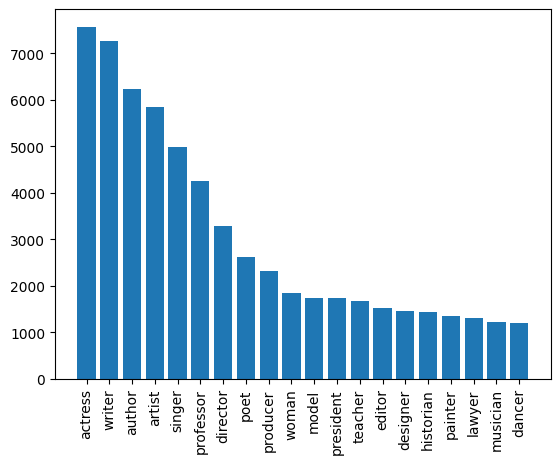

In [46]:
make_plot(overlapping_occ_counts_s1_female_all)

{'actress': 7568, 'businesswoman': 1106, 'host': 790, 'comedian': 523, 'actor': 373, 'manager': 320, 'news anchor': 200, 'chairman': 152, 'businessperson': 85, 'police officer': 76, 'hostess': 71, 'chairwoman': 47, 'meteorologist': 47, 'headmistress': 41, 'businessman': 25, 'comedienne': 17, 'flight attendant': 15, 'stuntwoman': 14, 'seamstress': 13, 'weather forecaster': 12}


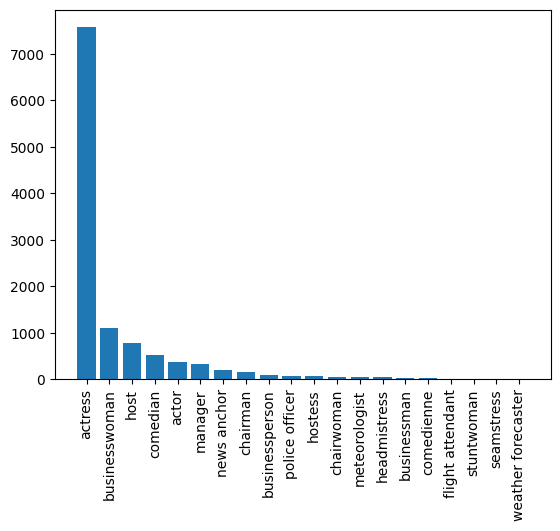

In [37]:
make_plot(overlapping_occ_counts_s1_female)

{'footballer': 9369, 'coach': 3265, 'writer': 3076, 'professor': 3068, 'author': 2897, 'director': 2707, 'football player': 2616, 'artist': 2485, 'businessman': 2433, 'producer': 2213, 'actor': 2101, 'lawyer': 2081, 'president': 1747, 'judge': 1566, 'musician': 1484, 'singer': 1477, 'chief': 1411, 'composer': 1182, 'painter': 1165, 'engineer': 1159}


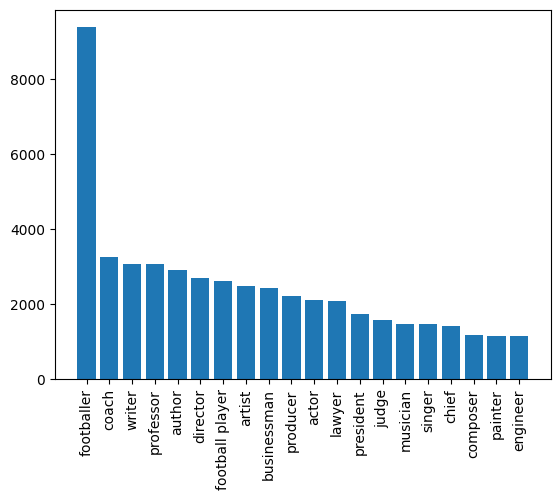

In [47]:
make_plot(overlapping_occ_counts_s1_male_all)

{'businessman': 2433, 'actor': 2101, 'manager': 947, 'chairman': 737, 'clergyman': 406, 'comedian': 353, 'host': 339, 'police officer': 121, 'businessperson': 84, 'headmaster': 54, 'meteorologist': 47, 'news anchor': 44, 'stuntman': 26, 'steward': 23, 'salesman': 20, 'firefighter': 18, 'policeman': 14, 'cameraman': 13, 'fireman': 11, 'actress': 11}


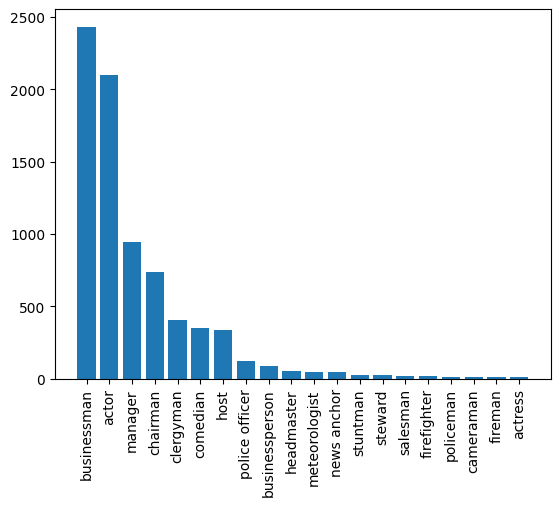

In [38]:
make_plot(overlapping_occ_counts_s1_male)

In [60]:
new_english_analysis(other_df)
overlapping_occ_counts_s1_other_all = Counter(chain.from_iterable(other_df['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1_other_all)
occ_titles_found_other = other_df[other_df['overlapping_occupations_sentence1'].map(len)>0]
print(occ_titles_found_other.shape[0])

All: 9284
No Whitespace: 1046
With Whitespace: 8238
0              [author, social worker]
2     [actress, artist, queen, artist]
3                    [actor, reporter]
4                           [director]
5                              [woman]
7                            [actress]
8                            [actress]
9                             [artist]
10           [painter, woman, painter]
11       [singer, actress, sex worker]
Name: overlapping_occupations_sentence1, dtype: object
Counter({'actress': 90, 'writer': 75, 'singer': 63, 'artist': 48, 'author': 43, 'model': 42, 'woman': 35, 'actor': 31, 'producer': 21, 'director': 20, 'musician': 18, 'poet': 16, 'queen': 14, 'comedian': 13, 'designer': 9, 'professor': 9, 'host': 8, 'painter': 7, 'executive director': 7, 'dancer': 7, 'drag performer': 6, 'lady': 6, 'composer': 6, 'lawyer': 6, 'playwright': 5, 'photographer': 5, 'psychologist': 5, 'teacher': 5, 'editor': 5, 'sociologist': 5, 'manager': 4, 'choreographer': 4, 'social

In [62]:
new_english_analysis(other_df)
overlapping_occ_counts_s1_other = Counter(chain.from_iterable(other_df['overlapping_occupations_sentence1']))
print(overlapping_occ_counts_s1_other)
occ_titles_found_other = other_df[other_df['overlapping_occupations_sentence1'].map(len)>0]
print(occ_titles_found_other.shape[0])

All: 62
No Whitespace: 54
With Whitespace: 8
0            []
2     [actress]
3       [actor]
4            []
5            []
7     [actress]
8     [actress]
9            []
10           []
11    [actress]
Name: overlapping_occupations_sentence1, dtype: object
Counter({'actress': 90, 'actor': 31, 'comedian': 13, 'host': 8, 'manager': 4, 'businesswoman': 1, 'businessman': 1})
131
